In [1]:
import torch
import torchvision 
from torchvision import transforms, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
from PIL import Image
import seaborn as ss

In [2]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}

In [3]:
batch_size = 64

data_transforms = {
    
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((254,254)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((254,254)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

In [4]:
data_set={
        'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
        'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
         }

In [5]:
data_loader={
        'train': torch.utils.data.DataLoader(data_set['train'], batch_size=64,shuffle=True),
        'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=32,shuffle=False),
        }

In [6]:
_ = data_set['valid'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}


In [7]:
cat_to_name

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [8]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = True


In [9]:
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1024,256)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(32,3)),
    ('out', nn.LogSoftmax(dim=1)),
]))


In [10]:
from tqdm.notebook import tqdm

In [11]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [13]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 25
valid_loss_min = np.Inf

In [14]:
device = 'cuda'

In [15]:
model = model.cuda()

In [17]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(data_loader['train']):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(data_loader['train'])
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(data_loader['train'])
    train_loss_hist.append(avg_train_loss)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(data_loader['valid']):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(data_loader['valid'])
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(data_loader['valid'])
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'DenseNet_size480.pt')
            
            valid_loss_min = avg_valid_loss
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (inf --> 2.766363).   Saving model ...
Epoch : 1 Train Loss : 0.383504 Train Acc : 0.862858
Epoch : 1 Valid Loss : 2.766363 Valid Acc : 0.500289


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (2.766363 --> 1.535106).   Saving model ...
Epoch : 2 Train Loss : 0.266016 Train Acc : 0.905117
Epoch : 2 Valid Loss : 1.535106 Valid Acc : 0.611400


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (1.535106 --> 0.768935).   Saving model ...
Epoch : 3 Train Loss : 0.253732 Train Acc : 0.913107
Epoch : 3 Valid Loss : 0.768935 Valid Acc : 0.709491


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.226444 Train Acc : 0.922428
Epoch : 4 Valid Loss : 2.868958 Valid Acc : 0.391204


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.221070 Train Acc : 0.924837
Epoch : 5 Valid Loss : 1.933684 Valid Acc : 0.505498


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.211186 Train Acc : 0.929341
Epoch : 6 Valid Loss : 2.650412 Valid Acc : 0.540799


  0%|          | 0/281 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
!nvidia-smi

Sun Oct  3 13:48:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GT 710      Off  | 00000000:01:00.0 N/A |                  N/A |
| 40%   54C    P8    N/A /  N/A |    174MiB /  2000MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

Text(0, 0.5, 'Accuracy')

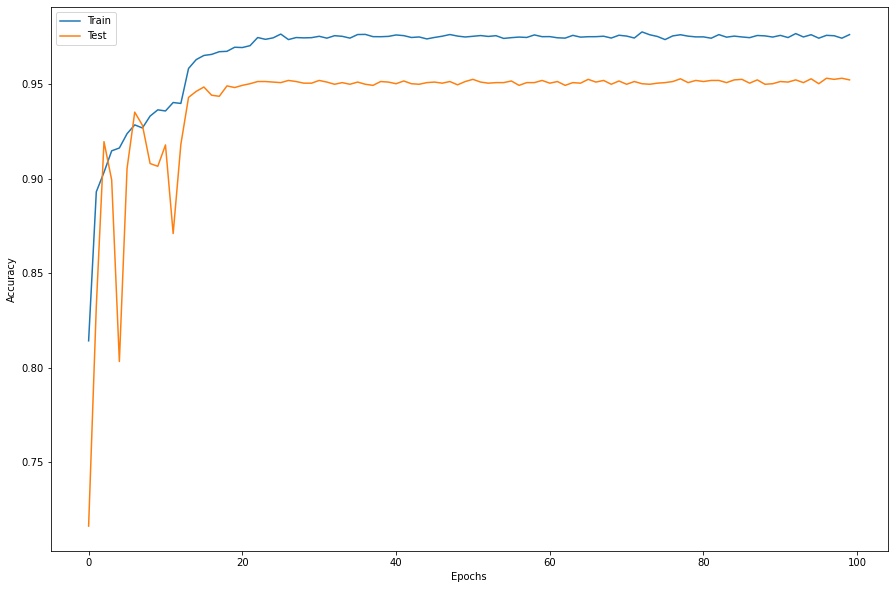

In [17]:
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

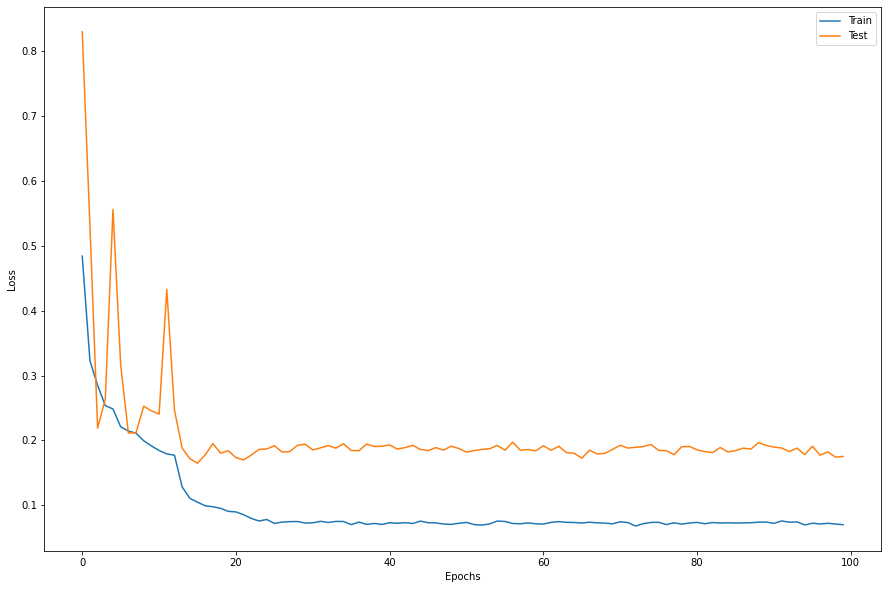

In [18]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [21]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(data_loader['valid'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

0it [00:00, ?it/s]

In [26]:
import pandas as pd
import seaborn as sns

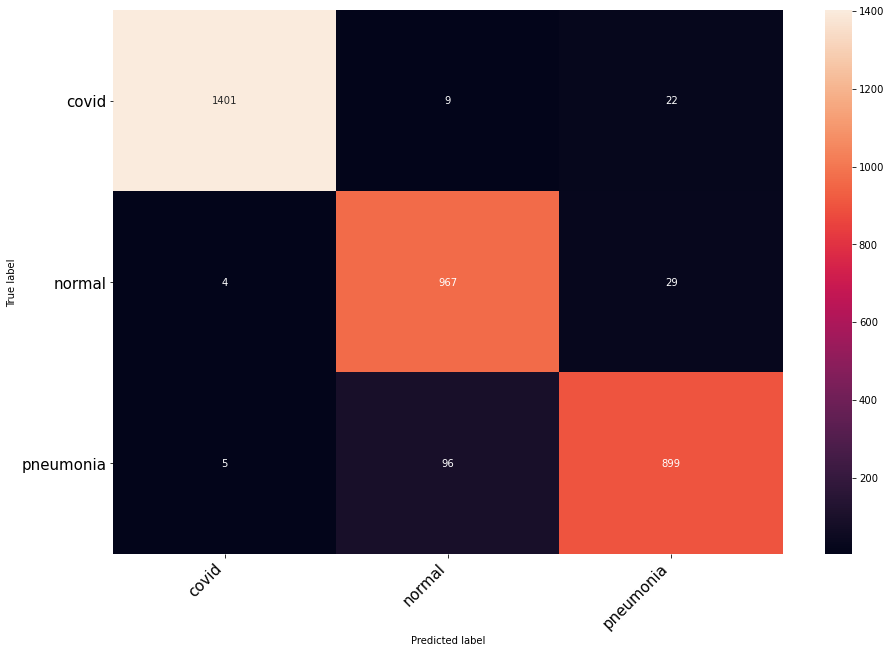

In [27]:
plt.figure(figsize=(15,10))

class_names = data_loader['valid'].dataset.classes
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/Densenet_100epochs.png")

### Evaluation

In [13]:
import pandas as pd
import os

In [14]:
from torch.utils.data import Dataset

In [15]:
path2weights="/media/brats/DRIVE1/akansh/DeepXrays/Notebooks/Chest-XR-Grand_challenge/DenseNet_final.pt"
model.load_state_dict(torch.load(path2weights)['model_state_dict'])

<All keys matched successfully>

In [16]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model=model.to(device)

In [21]:
class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform):
        filenames = os.listdir(image_loc)
        self.full_filenames = [os.path.join(image_loc,f) for f in filenames]
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]
        
     
        
        
        

In [22]:
test_data = covid_dataset(image_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/",
                         label_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv",
                         transform = data_transforms['valid'])

In [23]:
for x,y in test_data:
    print(x.shape)
    print(y)
    break

torch.Size([3, 254, 254])
nan


In [24]:
import time

In [25]:
def deploy_model(model, dataset, device, num_classes = 3, sanity_check = False):
    len_data = len(dataset)
    y_out=torch.zeros(len_data,num_classes)
    y_gt=np.zeros((len_data),dtype="uint8")
    model=model.to(device)
    elapsed_times=[]
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y = dataset[i]
#             y_gt[i] = y
            start=time.time()
            y_out[i]=model(x.unsqueeze(0).to(device))
            elapsed=time.time()-start
            elapsed_times.append(elapsed)
            if sanity_check is True:
                break
            inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms "%(device,inference_time))
    return y_out.numpy(),y_gt
        

In [26]:
y_test_out,_=deploy_model(model,test_data, device,sanity_check=False)

  0%|          | 0/1200 [00:00<?, ?it/s]

average inference time per image on cuda: 35.37 ms 


In [45]:
# for i in os.listdir("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"):
#     if plt.imread("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"+i).shape ==(512,512):
#         print(i)

In [27]:
y_test_out

array([[-2.8982472e+00, -7.5134826e+00, -5.7274763e-02],
       [-9.8456621e+00, -9.1474829e+00, -1.5937012e-04],
       [-1.3654736e+01, -7.0618483e-04, -7.2576232e+00],
       ...,
       [-2.2830627e+01, -1.8851963e+01,  0.0000000e+00],
       [-2.3314594e+01, -3.9748396e-04, -7.8304758e+00],
       [-1.4693987e+01, -4.3810062e+00, -1.2592212e-02]], dtype=float32)

In [69]:
y_test_out

array([[-2.8982472e+00, -7.5134826e+00, -5.7274763e-02],
       [-9.8456621e+00, -9.1474829e+00, -1.5937012e-04],
       [-1.3654736e+01, -7.0618483e-04, -7.2576232e+00],
       ...,
       [-2.2830627e+01, -1.8851963e+01,  0.0000000e+00],
       [-2.3314594e+01, -3.9748396e-04, -7.8304758e+00],
       [-1.4693987e+01, -4.3810062e+00, -1.2592212e-02]], dtype=float32)

In [28]:
y_test_pred=np.argmax(y_test_out,axis=1)

In [30]:
np.unique(y_test_pred, return_counts=True)

(array([0, 1, 2]), array([398, 433, 369]))

In [31]:
y_test_pred[10]

0

In [32]:
os.listdir("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/")[9]

'0010.jpg'

In [33]:
plt.imread("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"+os.listdir("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/")[10]).shape

(512, 512)

In [90]:
test_csv = pd.read_csv("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv")

In [100]:
test_csv[' class'] = y_test_pred

In [103]:
test_csv.to_csv('first_sub_akansh.csv', index = False)